# Harvesting Census Data (for use in Tableau...and anywhere else)

Exploring the US Census API for accessing datasets

Workbook by Sarah Battersby 

The US Census has a ton of interesting data...and you can access it easily with their API.  While it's possible to download data through the nice interface in [data.census.gov](https://data.census.gov/cedsci/), if you want to get a LOT of data (e.g., Census tracts for the entire US), it is a little limited.  For small geographic units, you can often only get a single state worth of data at a time.  That take a long time to download manually...and then you have to put all the files together into one. 

It's way nicer to just automate!  Let Python do the work for you!

In this notebook, I'll walk through some background on using the Census API, provide an example of grabbing Census tract-level data for the entire United States, and write out a single CSV at the end.


### Libraries and links of interest
If you'd like a bit of background reading - these are very helpful documents!
* [Census API documentation](https://www.census.gov/content/dam/Census/library/publications/2020/acs/acs_api_handbook_2020.pdf)
* [Census Data API Discovery Tool](https://www.census.gov/data/developers/updates/new-discovery-tool.html) - includes links to check the geographic levels of detail available and the names / IDs for attributes.  This is super useful for finding the right elements to put into your call to the Data API
* [ACS Guidance for Data Users](https://www.census.gov/programs-surveys/acs/guidance.html) - most of my data searches are for American Community Survey (ACS) data, so this guide is pretty handy for a reference

#### Import some libraries!
In this workbook, I'll use a series of Python libraries to connect to the Census data and process it to export into a CSV
* [Pandas](https://pandas.pydata.org/) - **Pandas** is a GO TO for data analysis and manipulation!
* [Requests](https://requests.readthedocs.io/en/master/) - **Requests** is what I normally use for calling out to URLs.  It's easy and does what I need.  You can use whatever you prefer (if you have a preference...)

In [1]:
import requests 
import pandas as pd

### Get organized and figure out what data you want to access
The first thing you need to do to use the Census API successfully is figure out the answer to three questions:
1. <b>What product?</b> 
* Example - 2018 ACS 5-year estimates or 2019 1-year estimates 

2. <b>What data table / attribute? </b>
* Example - B99104_007E, also known as the "IMPUTATION OF LENGTH OF TIME GRANDPARENT RESPONSIBLE FOR OWN GRANDCHILDREN UNDER 18 YEARS FOR THE POPULATION 30 YEARS AND OVER"

3. <b>What geographic level? </b>
* Example - Census Tract

And you want to make sure that the data that you want exists at the geographic level that you need in the product that you are using.  The product you end up working with my just be dependent on which one provides the right combination of attribute and geographic level to get the data that you need.  For instance, if you want Tract-level data, you can't get that from the 2019 ACS 1-year data, but you *can* get it from the 2018 ACS 5-year data.

#### Option 1: Census Data API Discovery Tool
You can find all of these details in the [Census Data API Discovery Tool](https://api.census.gov/data.html) using the handy tables (available as [html](https://api.census.gov/data.html), [xml](https://api.census.gov/data.xml), and [json](https://api.census.gov/data.json)!)

Here is how I would use the HTML table:
* Scroll to the year that I'm interested in - the table is sorted chronologically.  If I want the most recent data options I'll go all the way to the end.
* Skim the list to find either a data table name (first column) or some description (second column) that sounds like what you want
* Click on the variables (7th column) to see if your variable of interest is available for that dataset
* Click on the geographies link (6th column) to check if your geography of interest is available for that dataset


Of course, it's helpful if you already know what type of data table you're looking for.  I'd say that 99% of my searches are just for American Community Survey (ACS) data, so that does make it a bit faster for me...


#### Option 2: The Census data explorer: data.census.gov
Another option is the Census data explorer for an easy, graphical way of finding the information you need - and previewing the data for a subset of locations of interest at the same time.  It's a nice way to check the data available and to make sure you can get it for the geographic level of detail that you want and that the attributes seem like what you really want. 

And, if you really just need a small bit of data, maybe you can just get everything you need here and won't have to use the API for anything.  But...if you want to collect data for a large area and don't want to manually select all of the locations of interest, you will probably want to use the API to make it easier on yourself.

Here is the link to the explorer for the 2018 ACS 5 year data for an example: 

https://data.census.gov/cedsci/table?q=B01001&g=0400000US01&tid=ACSDT5Y2018.B01001&hidePreview=false

This gives me information on 
* Table ID / Name (B01001)
* confirms the product that I'm working with (2018: ACS 5-Year Estimates Detailed Tables)
* Attributes available (the table underneath...and we can reference any of the attributes by ROW number)
    * So - B01001_001E is the estimated value for row 1 (total population, estimate)
    * B01001_002E is the estimated value for row 2 (Male population, estimate)
    * B01001_002M is the margin of error for row 2 (Male population, margin of error)
    * etc.




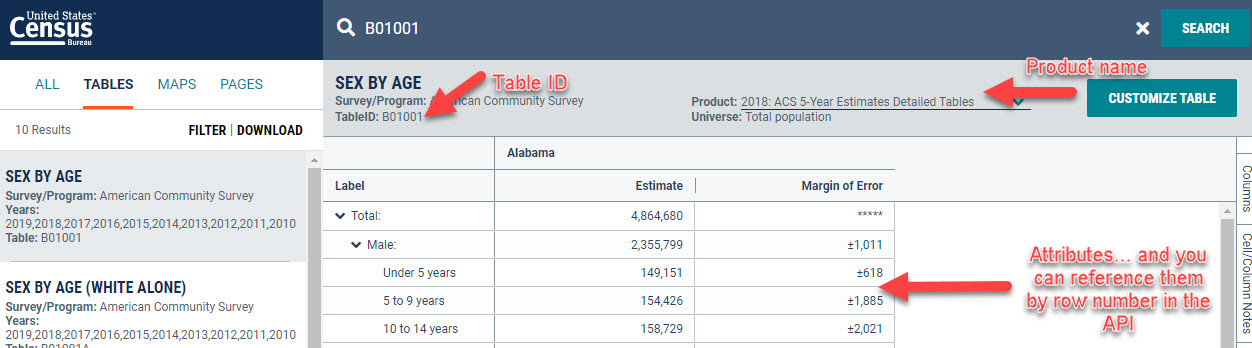

#### Option 3: I'm not sure if this is super lazy or super nerd or just stupid, but...
Once you are comfortable with the structure of a call to the Census API, you can also try out connecting to a data source and figure out whether your data and/or geography is available just by sending over kinda random requests.  (I'd never be this lazy...okay, yes I do this sort of stupid thing regularly because I can often remember the general structure of a call to the API more easily than I can remember the link to the above sites - but maybe now that I'm writing this notebook I'll be smarter)

For instance, this request for State level data from the 2019 1-year data will get a valid response:
* https://api.census.gov/data/2019/acs/acs1?get=NAME&for=state:01


This request for Tract level data from the 2019 1-year ACS data will **NOT** get a valid response:
* https://api.census.gov/data/2019/acs/acs1?get=NAME&for=tract:*&in=state:01


But this request for Tract level data from the 2018 ACS 5-year data will get a valid response:
* https://api.census.gov/data/2018/acs/acs5?get=NAME&for=tract:*&in=state:01

### Enough background, let's see the API and get some data!
The basics of a request to the API is this:
* https:// api.census. gov/data/**{dataset}**/**{get function with a list of variables and geography}**







Or, as the [Census ACS API handbook](https://www.census.gov/content/dam/Census/library/publications/2020/acs/acs_api_handbook_2020.pdf) so nicely describes it: 

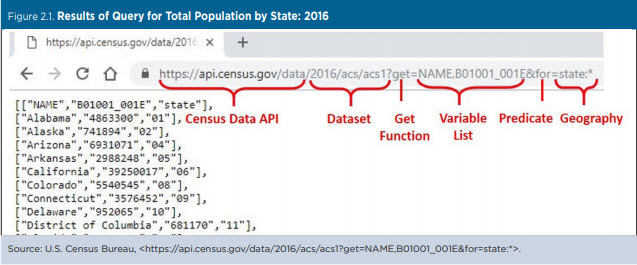

I am going to use an example with _Census Tract_ level data from the American Community Survey (ACS) 5-year data from 2018.

Since I want _Tract_ level data, I need to access through the appropriate hierarchy - you can't just request all tracts in the US in one call, but you can request all tracts for a _state_ through a call to the API. 

Here is an example of requesting one state of data using a state -> tract hierarchy.

If I just want one state of data, I can just use a simple URL - for instance:
* https://api.census.gov/data/2018/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:01

will retrieve a table with the B01001_001E attribute (population count) for every tract in Alabama

In [5]:
url = "https://api.census.gov/data/2018/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:01"
    
# call out and get the data
response = requests.get(url)

# print the first few records as 'proof' that this actually did something
# the first record is the header; subsequent records are the data
response.json()[:3]

[['NAME', 'B01001_001E', 'state', 'county', 'tract'],
 ['Census Tract 57.01, Jefferson County, Alabama',
  '2462',
  '01',
  '073',
  '005701'],
 ['Census Tract 107.04, Jefferson County, Alabama',
  '4993',
  '01',
  '073',
  '010704']]

### Where can you get FIPS codes for states?

Wikipedia is always a nice resource: https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code

You can also be lazy, like me, and harvest from the Census using their API (and then turn that into a list to walk through and scrape data for every state...)

We can just send a call over to the API that just asks for the NAME for every state (state:*)
* https://api.census.gov/data/2018/acs/acs5?get=NAME&for=state:*

Here is an example... and we'll then turn that result into a Pandas DataFrame

In [14]:
url = "https://api.census.gov/data/2018/acs/acs5?get=NAME&for=state:*"

# call out and get the data
response = requests.get(url)

# Turn the result into a list of FIPS codes
# Turning the JSON return from the request to the Census API into a Pandas DataFrame
df = pd.DataFrame.from_records(
    response.json()[1:], # the data
    columns=response.json()[0] # the headers / column names
)

# show first five records
df.iloc[:5]              

,NAME,state
0,Minnesota,27
1,Mississippi,28
2,Missouri,29
3,Montana,30
4,Nebraska,31


To make it even easier and clearer in the code that will harvest the ACS data, we can turn just the FIPS codes into a list that we can then walk through to call up data for each state.  

Note that _you don't have to turn the data into a list_ - I just thought it might make things a little clearer in terms of explaining to people who don't use Pandas or Python or script a bunch of stuff...

In [15]:
fips_codes = list(df.state)

# Sort them so they are in order, just because...
# you don't have to do that, but I like them to count up nicely
fips_codes.sort()

# show the first five records
fips_codes[:5]

['01', '02', '04', '05', '06']

### Put it together!
Now let's put together our original call out to the Census API to get the population data (the B01001_001E attribute) at the _Tract_ level for a single state and now we'll collect the data for _every_ state

It's as easy as walking through the list of FIPS codes that we just made

In [18]:
# Iterate through each FIPS code in the list
for i in range(0, len(fips_codes)):
    # just printing out a note on what location is being queried, delete or comment out as you see fit!
    print(f"Harvesting from FIPS {fips_codes[i]}")
    
    # set the URL with the FIPS code and attribute of interest
    # I'm using a string for the attribute and putting it into the URL as a variable, but you could just hard code it if you prefer
    # For fun, I'm demonstrating how to request multiple attributes at the same time...
    attribute = "B01001_001E,B01001_002E"
    url = f"https://api.census.gov/data/2018/acs/acs5?get=NAME,{attribute}&for=tract:*&in=state:{fips_codes[i]}"
    
    # call out and get the data
    response = requests.get(url)
    # the field names are in the first row, so grab those for col headers
    if i == 0: # make the df and set the headers
        df = pd.DataFrame.from_records(
            response.json()[1:], 
            columns=response.json()[0]
            )
    else: # make and tack on the next state of data
        df2 = pd.DataFrame.from_records(
            response.json()[1:], 
            columns=response.json()[0]
            )
        df = df.append(df2)

Harvesting from FIPS 01
Harvesting from FIPS 02


#### Check out the results
The script has just grabbed a ton of data, what does it look like?

Check it out by pulling up the first few rows from the DataFrame

In [19]:
df.iloc[:3]

,NAME,B01001_001E,B01001_002E,state,county,tract
0,"Census Tract 57.01, Jefferson County, Alabama",2462,1230,01,073,005701
1,"Census Tract 107.04, Jefferson County, Alabama",4993,2064,01,073,010704
2,"Census Tract 129.08, Jefferson County, Alabama",6048,2782,01,073,012908


### Turn your DataFrame into a CSV
Now we have a ton of data, we just have to drop it somewhere.  

It's super easy - we'll just use the built in tools to export the DataFrame to a CSV

If you really want, you could use the Tableau Hyper API to turn it into a .hyper file, but I'm not going to walk through that now...

In [17]:
# name it whatever you want, and save it wherever you want!
df.to_csv(r"c:\temp\my_census_data.csv")